<a href="https://colab.research.google.com/github/jeffwng5177/ECE1512-2023F-ProjectRepo-JeffreyWang/blob/main/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [3]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Data loading

In [4]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Model creation

In [6]:
# test {"output": "ignore"}

# Build CNN teacher.
cnn_model = tf.keras.Sequential()

# your code start from here for stpe 2
#add conv 3x3 chnl 32
cnn_model.add(tf.keras.layers.Conv2D(32,(3,3), strides=(1, 1), padding="same", activation='relu', input_shape=(28,28,1)))
#add pooling stride 1
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=1))
#add conv 3x3 chnl 64
cnn_model.add(tf.keras.layers.Conv2D(64,(3,3), strides=(1, 1), padding="same", activation='relu'))
#add pooling stride 2
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
#add flatten
cnn_model.add(tf.keras.layers.Flatten())
# add dropout rate
cnn_model.add(tf.keras.layers.Dropout(0.5))
#add dense layer 128
cnn_model.add(tf.keras.layers.Dense(128, activation='relu'))
#add dropout rate
cnn_model.add(tf.keras.layers.Dropout(0.5))
#add output layer
cnn_model.add(tf.keras.layers.Dense(10))
cnn_model.summary()


# Build fully connected student.
fc_model = tf.keras.Sequential()

# your code start from here for step 2

fc_model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
fc_model.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model.add(tf.keras.layers.Dense(784, activation='relu'))
#ad output layer
fc_model.add(tf.keras.layers.Dense(10))
fc_model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dropout (Dropout)           (None, 10816)            

# Teacher loss function

In [10]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=subclass_logits)


  return cross_entropy_loss_value

# Student loss function

In [11]:
# test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits / temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits,student_subclass_logits,DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.keras.losses.categorical_crossentropy(labels, student_subclass_logits, from_logits=True)

  loss= ALPHA * distillation_loss_value + (1-ALPHA) * cross_entropy_loss_value

  return loss


# Train and evaluation

In [12]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.optimizers.Adam(learning_rate=0.001)
  import time
  accuracy_matrix={}
  time_matrix=[]

  for epoch in range(1, NUM_EPOCHS + 1):
    start_time = time.time()
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images,labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num,a, b = compute_num_correct(model, images, labels)
      num_correct += num
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))

    accuracy_matrix.update({"Student Accuracy": num_correct / num_total * 100})
    epoch_time = time.time() - start_time
    time_matrix.append(epoch_time)
    print("Total time per epoch: {0:.2f} seconds".format(epoch_time))
    total_time = np.sum(time_matrix)
    print("Total time of training this model: {0:.2f} seconds".format(total_time))
    return accuracy_matrix

# Training models

In [13]:
# your code start from here for step 5
import numpy as np
# train Teacher and Student model using training dataset
ALPHA=0.5
DISTILLATION_TEMPERATURE = 4

# train and evaluate Teacher model
teacher_matrix = train_and_evaluate(cnn_model, compute_teacher_loss)
#99.24%

# train and evaluate Student model
matrix = train_and_evaluate(fc_model, compute_student_loss)
#98.84%


Epoch 1: 

Class_accuracy: 98.05%
Total time per epoch: 20.69 seconds
Total time of training this model: 20.69 seconds
Epoch 1: Class_accuracy: 96.87%
Total time per epoch: 10.87 seconds
Total time of training this model: 10.87 seconds


# Test accuracy vs. tempreture curve

Epoch 1: Class_accuracy: 96.77%
Total time per epoch: 20.34 seconds
Total time of training this model: 20.34 seconds
Epoch 1: Class_accuracy: 96.97%
Total time per epoch: 11.08 seconds
Total time of training this model: 11.08 seconds
Epoch 1: Class_accuracy: 96.91%
Total time per epoch: 10.80 seconds
Total time of training this model: 10.80 seconds
Epoch 1: Class_accuracy: 96.50%
Total time per epoch: 10.87 seconds
Total time of training this model: 10.87 seconds
Epoch 1: Class_accuracy: 96.21%
Total time per epoch: 10.92 seconds
Total time of training this model: 10.92 seconds
Epoch 1: Class_accuracy: 96.45%
Total time per epoch: 10.97 seconds
Total time of training this model: 10.97 seconds
Epoch 1: Class_accuracy: 96.74%
Total time per epoch: 10.78 seconds
Total time of training this model: 10.78 seconds
Epoch 1: Class_accuracy: 96.83%
Total time per epoch: 11.51 seconds
Total time of training this model: 11.51 seconds
Epoch 1: Class_accuracy: 96.90%
Total time per epoch: 10.86 seco

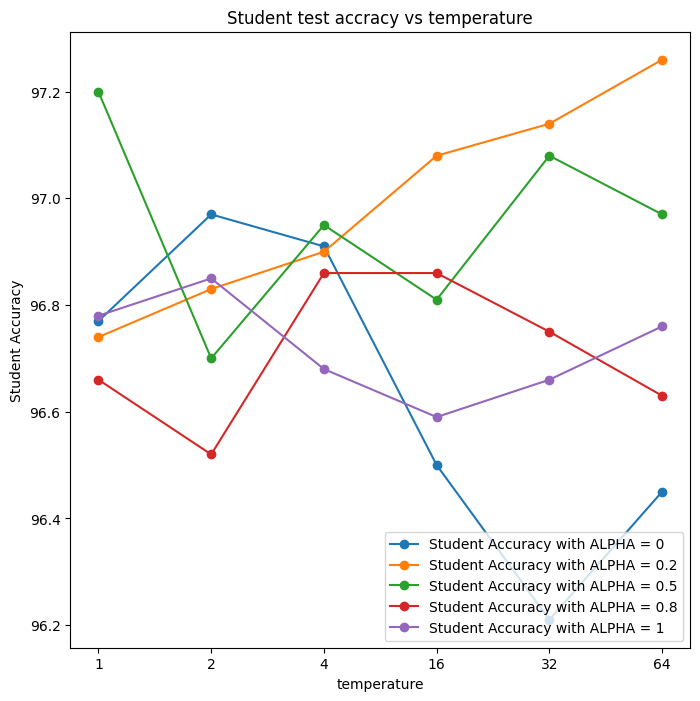

In [13]:
# your code start from here for step 6
import matplotlib.pyplot as plt


Temperatures = [1,2,4,16,32,64]
ALPHAS=[0, 0.2, 0.5, 0.8, 1]
student_accuracy_matrixes = {}
for a in ALPHAS:
  ALPHA = a
  accracy_among_t = []
  for t in Temperatures:
    DISTILLATION_TEMPERATURE = t
    tf.keras.backend.clear_session()
    fc_model = tf.keras.models.clone_model(fc_model)
    matrix = train_and_evaluate(fc_model, compute_student_loss)
    accracy_among_t.append(matrix.get('Student Accuracy').numpy())
  student_accuracy_matrixes[ALPHA] =  accracy_among_t


acc_0 = student_accuracy_matrixes.get(ALPHAS[0])
acc_1 = student_accuracy_matrixes.get(ALPHAS[1])
acc_2 = student_accuracy_matrixes.get(ALPHAS[2])
acc_3 = student_accuracy_matrixes.get(ALPHAS[3])
acc_4 = student_accuracy_matrixes.get(ALPHAS[4])

plt.figure(figsize=(8, 8))
plt.title('Student test accracy vs temperature')
plt.xlabel('temperature')
plt.ylabel('Student Accuracy')
xi = list(range(len(Temperatures)))

plt.plot(acc_0,linestyle='-', marker='o', label='Student Accuracy with ALPHA = 0')
plt.plot(acc_1,linestyle='-', marker='o', label='Student Accuracy with ALPHA = 0.2')
plt.plot(acc_2,linestyle='-', marker='o', label='Student Accuracy with ALPHA = 0.5')
plt.plot(acc_3,linestyle='-', marker='o', label='Student Accuracy with ALPHA = 0.8')
plt.plot(acc_4,linestyle='-', marker='o', label='Student Accuracy with ALPHA = 1')

plt.xticks(xi, Temperatures)
plt.legend(loc='lower right')
# plt.savefig('/content/images_minist/accuracyVStemperatures.png')
plt.show()

# Train student from scratch

In [20]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential()

# your code start from here for step 7
fc_model_no_distillation.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
fc_model_no_distillation.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(10))
fc_model_no_distillation.summary()


# test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits)

  return cross_entropy_loss


train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 784)               615440    
                                                                 
 dense_7 (Dense)             (None, 784)               615440    
                                                                 
 dense_8 (Dense)             (None, 10)                7850      
                                                                 
Total params: 1238730 (4.73 MB)
Trainable params: 1238730 (4.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1: Class_accuracy: 96.95%
Total time per epoch: 10.86 seconds
Total time of training this model: 10.86 seconds


{'Student Accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=96.95>}

# Comparing the teacher and student model (number of of parameters and FLOPs)

In [25]:
# your code start from here for step 8



# Implementing the state-of-the-art KD algorithm

In [ ]:
# your code start from here for step 12


# XAI method to explain models

In [ ]:
# your code start from here for step 13
